In [1]:
import pandas as pd
from scipy.stats import shapiro
import numpy as np

In [ ]:
horses = pd.read_csv("horse_winners_example.csv", sep=',')
horses

,pedigree,breed,favorable_proportions,trainer,training_frequency,age,has_disease,vet_care,special_feed,supplementation,win_probability
0,Winners,Arabian,1,Trainer C,4,4,0,0,0,1,0.65
1,Non-Winners,Thoroughbred,1,Trainer D,5,8,0,1,0,1,0.55
2,Winners,Thoroughbred,1,Trainer B,3,6,0,1,1,0,0.70
3,Winners,Mangalarga,0,Trainer D,4,7,0,1,0,1,0.55
4,Winners,Arabian,1,Trainer D,4,7,0,0,0,1,0.60
...,...,...,...,...,...,...,...,...,...,...,...
495,Winners,Thoroughbred,1,Trainer D,3,4,0,1,1,1,0.75
496,Winners,Thoroughbred,0,Trainer D,5,6,0,1,0,1,0.70
497,Non-Winners,Mangalarga,1,Trainer B,3,7,0,1,1,0,0.45
498,Winners,Mangalarga,0,Trainer C,4,3,0,0,1,1,0.60


In [ ]:
# Normality test
for c in ['training_frequency', 'age', 'win_probability']:
    if shapiro(horses[c]).pvalue > 0.05:
        print(f'{c} : normal distribution')
    else:
        print(f'{c} : non-normal distribution')

training_frequency : non-normal distribution
age : non-normal distribution
win_probability : non-normal distribution


In [5]:
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [6]:
"""
Plots feature importance for tree-based and linear models.

Parameters:
- model: trained model (e.g., RandomForest, XGBoost, LogisticRegression, etc.)
- feature_names: optional list of feature names
- top_n: optional integer to limit the number of features displayed
"""
def plot_feature_importance(model, feature_names=None, top_n=None):
    # Determine which attribute to use for importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        importance_label = "Feature Importance (Tree)"
    
    elif hasattr(model, 'coef_'):
        importances = model.coef_
        if importances.ndim == 1:
            importances = importances
        else:
            # If multiclass classification (multiple columns)
            importances = np.mean(np.abs(importances), axis=0)
        importances = np.abs(importances)
        importance_label = "Feature Importance (Linear Model - Coefficients)"
    
    else:
        raise ValueError("The model does not have 'feature_importances_' or 'coef_'. Not directly supported.")
    
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(len(importances))]
    
    # Sort the importances and names
    indices = np.argsort(importances)[::-1]
    if top_n:
        indices = indices[:top_n]
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(importance_label)
    plt.tight_layout()
    plt.show()

'''
Get feature names after preprocessing.
Note: intended to be used with the feature importance analysis function
'''
def get_feature_names(preprocessor):
    output_features = []
    for name, transformer, cols in preprocessor.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            trans_features = transformer.get_feature_names_out(cols)
        else:
            trans_features = cols  # If get_feature_names_out is not available
        output_features.extend(trans_features)
    return output_features


In [ ]:
cat_features = ['pedigree', 'breed', 'trainer']
num_features = ['favorable_proportions', 'training_frequency', 'age', 'has_disease',
                'vet_care', 'special_feed', 'supplementation']
features = num_features + cat_features

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(), cat_features)
])

x = horses[features]
y = horses['win_probability']

x_proc = preprocessor.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_proc, y, test_size=0.4, random_state=42)

# turning target to binary form to apply classification
threshold = 0.65
y_train_bin = (y_train >= threshold).astype(int)
y_test_bin = (y_test >= threshold).astype(int)

Random Forest Classifier
Accuracy:  0.92
Precision:  0.86
Recall:  0.89
R^2:  0.62


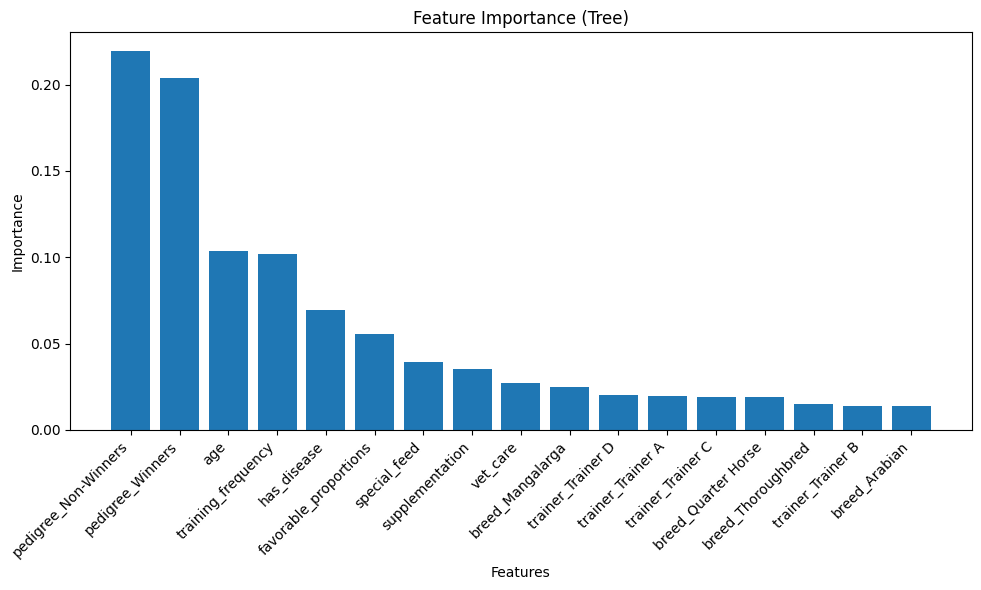

In [9]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

class_rf = RandomForestClassifier()
class_rf.fit(x_train, y_train_bin)
y_pred = class_rf.predict(x_test)

# Metrics for ROC/AUC Analysis
y_pred_proba = class_rf.predict_proba(x_test)[:, 1]
fpr_rf_class, tpr_rf_class, _ = roc_curve(y_test_bin, y_pred_proba)
auc_rf_class = roc_auc_score(y_test_bin, y_pred)    # score AUC

print("Random Forest Classifier")
print('Accuracy: ', round(accuracy_score(y_test_bin, y_pred), 2))
print('Precision: ', round(precision_score(y_test_bin, y_pred), 2))
print('Recall: ', round(recall_score(y_test_bin, y_pred), 2))
print('R^2: ', round(r2_score(y_test_bin, y_pred), 2))

plot_feature_importance(class_rf, get_feature_names(preprocessor))

Random Forest Regressor
Mean Squared Error:  0.0
Mean Absolute Error:  0.02
R^2:  0.95


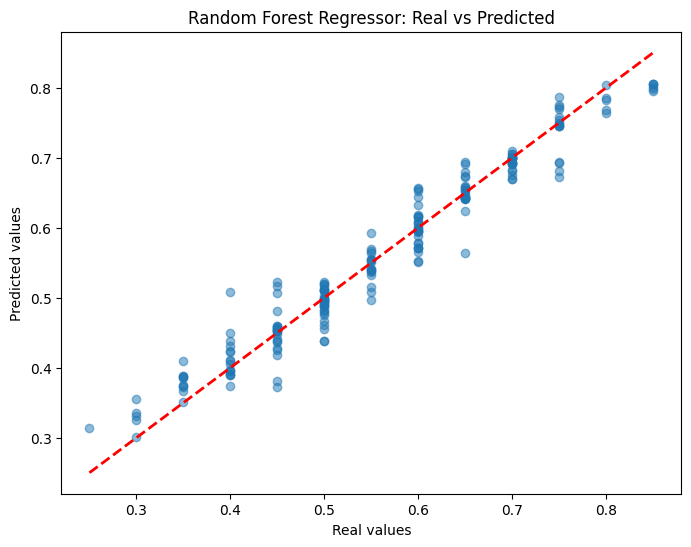

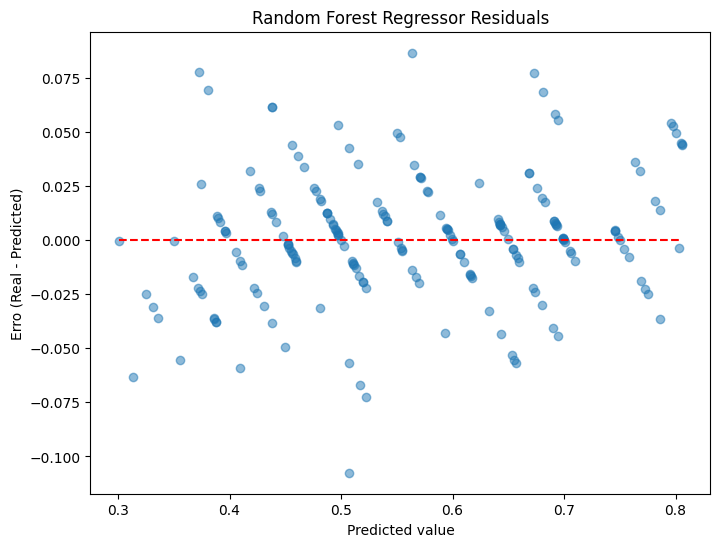

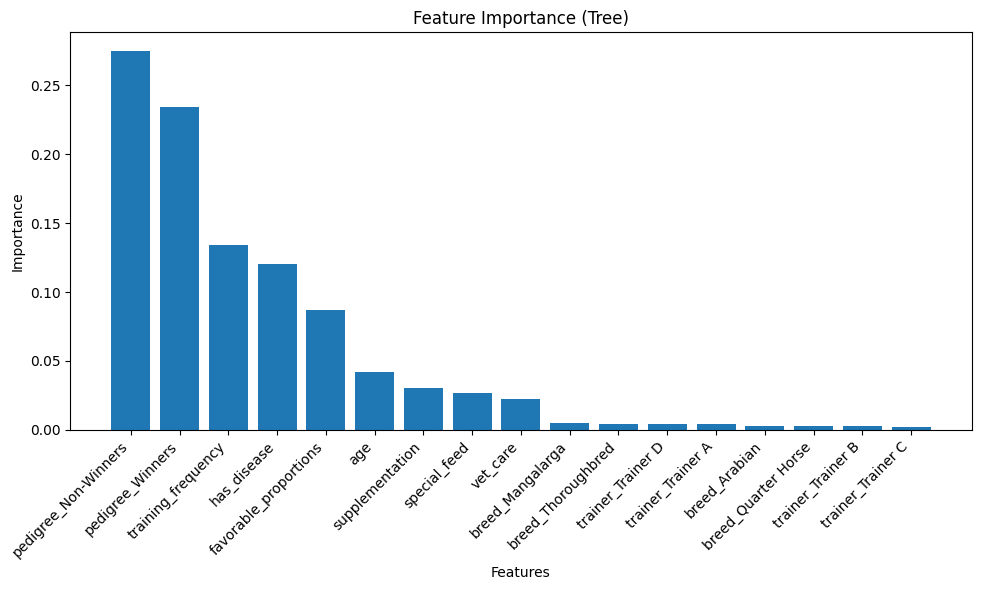

In [ ]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

reg_rf = RandomForestRegressor()
reg_rf.fit(x_train, y_train)
y_pred = reg_rf.predict(x_test)

# Metrics for ROC/AUC Analysis
fpr_rf_reg, tpr_rf_reg, _ = roc_curve(y_test_bin, y_pred_proba)
auc_rf_reg = roc_auc_score(y_test_bin, y_pred)    # score AUC

print("Random Forest Regressor")
print('Mean Squared Error: ', round(mean_squared_error(y_test, y_pred), 2))
print('Mean Absolute Error: ', round(mean_absolute_error(y_test, y_pred), 2))
print('R^2: ', round(r2_score(y_test, y_pred), 2))

# Real vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.title('Random Forest Regressor: Real vs Predicted')
plt.show()

# Residuals
errors = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, errors, alpha=0.5)
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), colors='r', linestyles='dashed')
plt.xlabel('Predicted value')
plt.ylabel('Erro (Real - Predicted)')
plt.title('Random Forest Regressor Residuals')
plt.show()

plot_feature_importance(reg_rf, get_feature_names(preprocessor))

In [11]:
# SVM Classifier
from sklearn.svm import SVC

class_svc = SVC(probability=True)
class_svc.fit(x_train, y_train_bin)
y_pred = class_svc.predict(x_test)

# Metrics for ROC/AUC Analysis
y_pred_proba = class_svc.predict_proba(x_test)[:, 1]
fpr_svc, tpr_svc, _ = roc_curve(y_test_bin, y_pred_proba)
auc_svc = roc_auc_score(y_test_bin, y_pred)    # score AUC

print("SVM Classifier")
print('Accuracy: ', round(accuracy_score(y_test_bin, y_pred), 2))
print('Precision: ', round(precision_score(y_test_bin, y_pred), 2))
print('Recall: ', round(recall_score(y_test_bin, y_pred), 2))
print('R^2: ', round(r2_score(y_test_bin, y_pred), 2))

SVM Classifier
Accuracy:  0.94
Precision:  0.94
Recall:  0.88
R^2:  0.73


Logistic Regression
Accuracy:  0.93
Precision:  0.9
Recall:  0.86
F1 Score:  0.88
R^2:  0.66


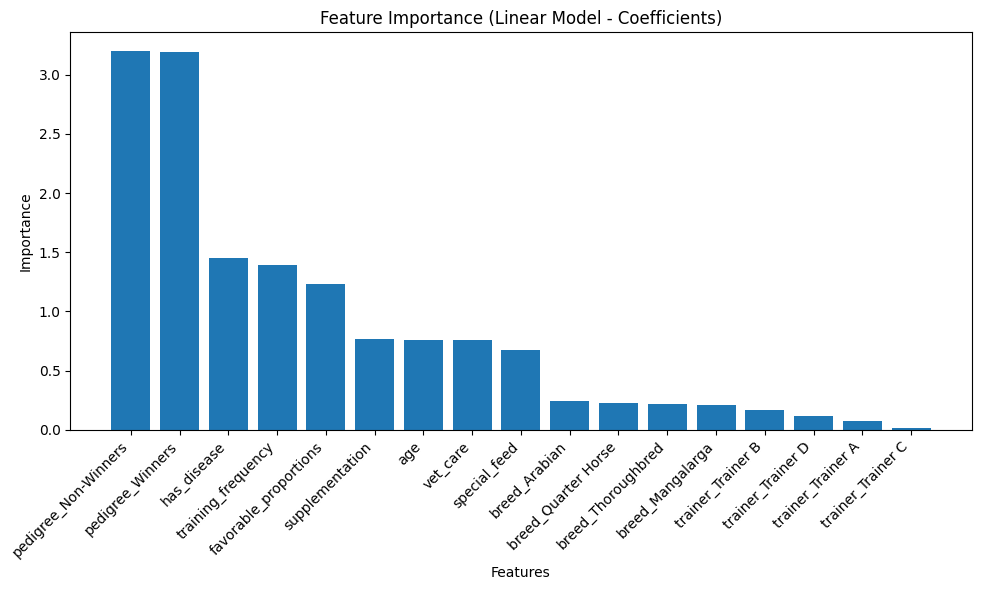

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train_bin)
y_pred = log_reg.predict(x_test)

# Metrics for ROC/AUC Analysis
y_pred_proba = log_reg.predict_proba(x_test)[:, 1]
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test_bin, y_pred_proba)
auc_log_reg = roc_auc_score(y_test_bin, y_pred)    # score AUC

print("Logistic Regression")
print('Accuracy: ', round(accuracy_score(y_test_bin, y_pred), 2))
print('Precision: ', round(precision_score(y_test_bin, y_pred), 2))
print('Recall: ', round(recall_score(y_test_bin, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test_bin, y_pred), 2))
print('R^2: ', round(r2_score(y_test_bin, y_pred), 2))

plot_feature_importance(log_reg, get_feature_names(preprocessor))

In [ ]:
# KNN Classifier - n=2
from sklearn.neighbors import KNeighborsClassifier

knn_class = KNeighborsClassifier(n_neighbors=2)
knn_class.fit(x_train, y_train_bin)
y_pred = knn_class.predict(x_test)

# Metrics for ROC/AUC Analysis
y_pred_proba = knn_class.predict_proba(x_test)[:, 1]
fpr_knn_class, tpr_knn_class, _ = roc_curve(y_test_bin, y_pred_proba)
auc_knn_class = roc_auc_score(y_test_bin, y_pred)    # score AUC

print("KNN Classifier (n=2)")
print('Accuracy: ', round(accuracy_score(y_test_bin, y_pred), 2))
print('Precision: ', round(precision_score(y_test_bin, y_pred), 2))
print('Recall: ', round(recall_score(y_test_bin, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test_bin, y_pred), 2))
print('R^2: ', round(r2_score(y_test_bin, y_pred), 2))

KNN Classifier
Accuracy:  0.85
Precision:  0.93
Recall:  0.59
F1 Score:  0.72
R^2:  0.32


In [16]:
# KNN Classifier - n=3
from sklearn.neighbors import KNeighborsClassifier

knn_class = KNeighborsClassifier(n_neighbors=3)
knn_class.fit(x_train, y_train_bin)
y_pred = knn_class.predict(x_test)

# Metrics for ROC/AUC Analysis
y_pred_proba = knn_class.predict_proba(x_test)[:, 1]
fpr_knn_class, tpr_knn_class, _ = roc_curve(y_test_bin, y_pred_proba)
auc_knn_class = roc_auc_score(y_test_bin, y_pred)    # score AUC

print("KNN Classifier (n=2)")
print('Accuracy: ', round(accuracy_score(y_test_bin, y_pred), 2))
print('Precision: ', round(precision_score(y_test_bin, y_pred), 2))
print('Recall: ', round(recall_score(y_test_bin, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test_bin, y_pred), 2))
print('R^2: ', round(r2_score(y_test_bin, y_pred), 2))

KNN Classifier (n=2)
Accuracy:  0.93
Precision:  0.88
Recall:  0.89
F1 Score:  0.89
R^2:  0.66


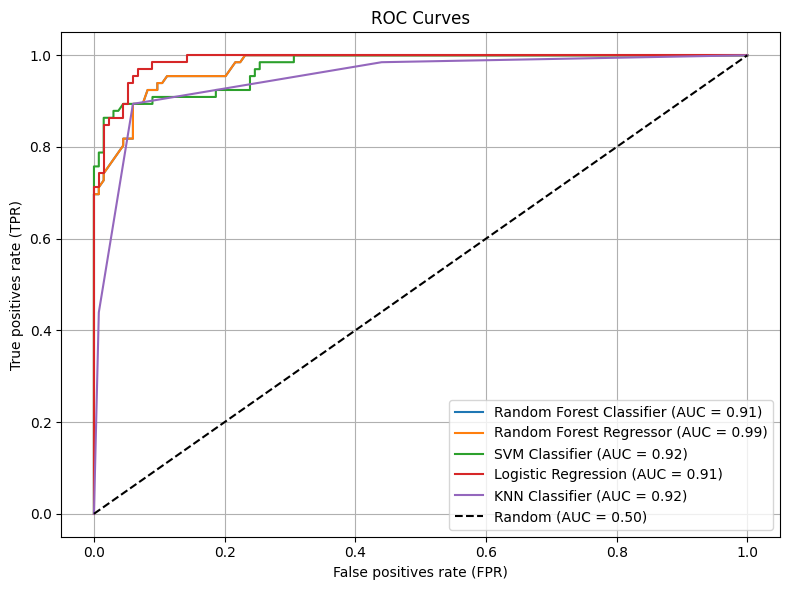

In [ ]:
## ROC Analysis
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_class, tpr_rf_class, label=f'Random Forest Classifier (AUC = {auc_rf_class:.2f})')
plt.plot(fpr_rf_reg, tpr_rf_reg, label=f'Random Forest Regressor (AUC = {auc_rf_reg:.2f})')
plt.plot(fpr_svc, tpr_svc, label=f'SVM Classifier (AUC = {auc_svc:.2f})')
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {auc_log_reg:.2f})')
plt.plot(fpr_knn_class, tpr_knn_class, label=f'KNN Classifier (AUC = {auc_knn_class:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.xlabel('False positives rate (FPR)')
plt.ylabel('True positives rate (TPR)')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Logistic regression was chosen because it gives more importance to the features desired.